first point ei_vals[ 179 ]= 0.3563832251021575
seed=	 [0.99238876 0.04252583 0.82650877] 	EI= 0.3740174749885551
best_x=	 [1.         0.18317451 0.78812552] 	EI= 0.3740174749885551
seed=	 [0.8538525  0.07227156 0.73167088] 	EI= 0.3740174749887303
best_x=	 [1.         0.18317447 0.78812543] 	EI= 0.3740174749887303
seed=	 [0.84699837 0.12446033 0.73359046] 	EI= 0.37401747498873184
best_x=	 [1.         0.18317438 0.78812543] 	EI= 0.37401747498873184
seed=	 [0.97168998 0.77466413 0.79113395] 	EI= 0.374017474988276
seed=	 [0.99902588 0.2621468  0.84904452] 	EI= 0.3740174749883389
seed=	 [0.58120575 0.54157946 0.41973755] 	EI= 0.3557723356531241
seed=	 [0.80877701 0.4321179  0.76633401] 	EI= 0.37401747498813354
seed=	 [0.93335779 0.44590564 0.73008591] 	EI= 0.3740174749887974
best_x=	 [1.         0.18317392 0.78812535] 	EI= 0.3740174749887974
seed=	 [0.9666624  0.45807956 0.83747142] 	EI= 0.37401747498869065
seed=	 [0.98102024 0.73205568 0.83042393] 	EI= 0.3740174749887977
best_x=	 [1.      

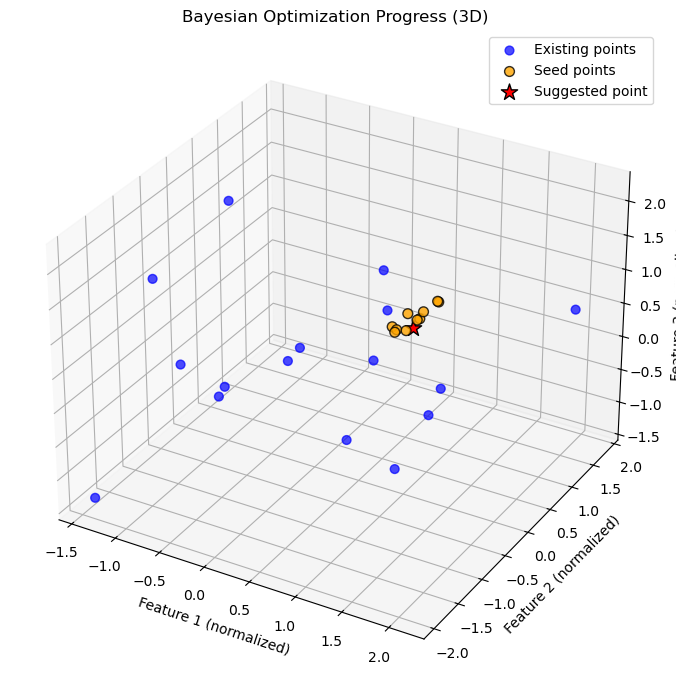

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy.optimize import minimize


# ------------------------------------------------------------
# Load initial data
# ------------------------------------------------------------
X = np.load("initial_inputs.npy")        # shape (n0, d)
y = np.load("initial_outputs.npy")       # shape (n0,)


# ------------------------------------------------------------
# Append new information
# ------------------------------------------------------------
X = np.append(X,[[0.000000, 0.000000, 0.000000]], axis=0)  # Append week1 inputs
y = np.append(y, -0.17522203024048644)         # Append week1 outputs

# Save the updated data
np.save("updated_inputs_PW1.npy", X)
np.save("updated_outputs_PW1.npy", y)


# ------------------------------------------------------------
# Normalise inputs and outputs
# ------------------------------------------------------------
x_scaler = StandardScaler()
Xn = x_scaler.fit_transform(X)

y_mean = y.mean()
y_std = y.std() if y.std() > 0 else 1.0
yn = (y - y_mean) / y_std                 # GP works better with normalized target


def visualize_iteration(Xn, seed_points, suggested_point):
    """
    Simple visualization of Bayesian Optimization iteration.
    Supports 2D and 3D inputs.
    
    Args:
        Xn: ndarray of shape (n, d) - existing normalized points
        seed_points: ndarray of shape (m, d) - seed points used in optimization
        suggested_point: ndarray of shape (d,) - next query point
    """
    d = Xn.shape[1]
    
    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(Xn[:, 0], Xn[:, 1], c='blue', label='Existing points', s=40, alpha=0.7)
        plt.scatter(seed_points[:, 0], seed_points[:, 1], c='orange', label='Seed points', s=50, alpha=0.7, edgecolors='k')
        plt.scatter(suggested_point[0], suggested_point[1], c='red', label='Suggested point', s=120, marker='*', edgecolors='k')

        plt.title("Bayesian Optimization Progress (2D)")
        plt.xlabel("Feature 1 (normalized)")
        plt.ylabel("Feature 2 (normalized)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif d == 3:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(Xn[:, 0], Xn[:, 1], Xn[:, 2], c='blue', label='Existing points', s=40, alpha=0.7)
        ax.scatter(seed_points[:, 0], seed_points[:, 1], seed_points[:, 2],
                   c='orange', label='Seed points', s=50, alpha=0.8, edgecolors='k')
        ax.scatter(suggested_point[0], suggested_point[1], suggested_point[2],
                   c='red', label='Suggested point', s=150, marker='*', edgecolors='k')

        ax.set_title("Bayesian Optimization Progress (3D)")
        ax.set_xlabel("Feature 1 (normalized)")
        ax.set_ylabel("Feature 2 (normalized)")
        ax.set_zlabel("Feature 3 (normalized)")
        ax.legend()
        plt.tight_layout()
        plt.show()

    else:
        print(f"Visualization not supported for {d}D inputs (only 2D or 3D).")

# ------------------------------------------------------------
# Fit a Gaussian Process surrogate
# ------------------------------------------------------------
d = X.shape[1]
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(d),
                                      length_scale_bounds=(1e-5, 1e5),
                                      nu=2.5)
kernel += WhiteKernel(noise_level=1e-6,
                      noise_level_bounds=(1e-10, 1e1))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=False,
                              n_restarts_optimizer=10,
                              random_state=0)
gp.fit(Xn, yn)

# ------------------------------------------------------------
# Define Expected Improvement acquisition (for maximization)
# ------------------------------------------------------------
f_best = yn.max()
xi = 0.01     # exploration parameter

def predict_raw(x_raw):
    """Predict mean and std in normalized GP space for a raw input x_raw."""
    x = np.atleast_2d(x_raw)
    xn = x_scaler.transform(x)
    mu, sigma = gp.predict(xn, return_std=True)
    return mu.ravel(), sigma.ravel()

def expected_improvement_raw(x_raw, xi=xi):
    """Compute EI for a raw input x_raw."""
    mu, sigma = predict_raw(x_raw)
    sigma = np.maximum(sigma, 1e-9)       # avoid division by zero
    z = (mu - f_best - xi) / sigma
    ei = (mu - f_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei.ravel()[0]

# ------------------------------------------------------------
# Search for the next query point
# ------------------------------------------------------------
# Domain is assumed to be [0,1]^d (based on inspection of initial data)
bounds = [(0.0, 1.0)] * d

# Global random search to find good seeds
n_seeds = 500
rng = np.random.default_rng(1)
candidates = rng.uniform(0.0, 1.0, size=(n_seeds, d))
ei_vals = np.array([expected_improvement_raw(c) for c in candidates])
best_idx = np.argmax(ei_vals)
print ("first point ei_vals[",best_idx,"]=", ei_vals[best_idx])

# Take top few seeds for local optimisation
seed_points = candidates[np.argsort(-ei_vals)[:10]]

best_x = None
best_val = -1.0
for s in seed_points:
    res = minimize(lambda xx: -expected_improvement_raw(xx),
                   x0=s,
                   bounds=bounds,
                   method="L-BFGS-B",
                   options={'maxiter':300})
    if res.success:
        val = -res.fun
        print ( "seed=\t", s, "\tEI=", val)
        #visualize_iteration(Xn, seed_points, best_x)
        if val > best_val:
            best_val = val
            best_x = res.x.copy()
            print ( "best_x=\t", best_x, "\tEI=", val )

# Fallback if optimizer fails
if best_x is None:
    best_x = candidates[best_idx]
    best_val = ei_vals[best_idx]

# ------------------------------------------------------------
# Report results
# ------------------------------------------------------------
suggested_point = np.atleast_1d(best_x)
mu_s, sigma_s = predict_raw(suggested_point.reshape(1, -1))

# Convert mean/std back to original y-scale
mu_orig = mu_s * y_std + y_mean
sigma_orig = sigma_s * y_std
next_query = "-".join([f"{xi:.6f}" for xi in suggested_point])

print("Suggested next query point (raw input space):", next_query)
print("Expected Improvement at this point (normalized):", best_val)
print("GP predicted mean at this point (original y scale):", mu_orig)
print("GP predicted stddev at this point (original y scale):", sigma_orig)

# Visualise
visualize_iteration(Xn, seed_points, best_x)